<a href="https://colab.research.google.com/github/Deep-Poets-Society/Deep-Comedy/blob/main/generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Colab Setup

import sys
import os

%cd /content
!rm -rf Deep-Comedy &> /dev/null
!git clone https://github.com/Deep-Poets-Society/Deep-Comedy &> /dev/null
%cd Deep-Comedy

sys.path.append(os.getcwd())

!pip install tensorflow &> /dev/null
!pip install tensorflow_text &> /dev/null

/content
/content/Deep-Comedy


In [2]:
from tokenizer import Tokenizer
import tensorflow as tf
import time
import numpy as np
import re
from matplotlib import pyplot as plt
from utils import load_dataset_for_gen, positional_encoding, loss_function, accuracy_function, plot_accuracy
from models import Transformer, create_masks
from schedules import CustomSchedule
from preprocessing import CESURA, SPACE, SYL, NEW_LINE
import random

In [3]:
dataset = load_dataset_for_gen()
train = dataset['train']
val = dataset['val']

In [4]:
tokenizer = Tokenizer(['[START]', '[END]', f'{SPACE}', f'{NEW_LINE}'], 'res/vocab_gen.txt')

In [5]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [6]:
def tokenize_pairs(X, y):
    X = tokenizer.tokenize(X)
    # Convert from ragged to dense, padding with zeros.
    X = X.to_tensor()

    y = tokenizer.tokenize(y)
    # Convert from ragged to dense, padding with zeros.
    y = y.to_tensor()

    return X, y


def make_batches(ds):
    return (ds
            .cache()
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE)
            .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE)
            )

In [7]:
train_batches = make_batches(train)
val_batches = make_batches(val)

Hyperparameters

In [8]:
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8
dropout_rate = 0.1

Set Adam Optimizer

In [9]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Loss and metrics

In [10]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')

Training and checkpoint


In [11]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizer.get_vocab_size().numpy(),
    target_vocab_size=tokenizer.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [12]:
restore_checkpoint = False

In [13]:
checkpoint_path = "./checkpoints-gen/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if restore_checkpoint and ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [14]:
EPOCHS = 200

In [15]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [16]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [17]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # inp -> X, tar -> y
  for (batch, entry) in enumerate(train_batches):
    inp = entry[0]
    tar = entry[1]
    train_step(inp, tar)

    #if batch % 50 == 0:
    #  print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 50 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
  
  for val_entry in val_batches:
    val_inp = val_entry[0]
    val_tar = val_entry[1]
    val_tar_inp = val_tar[:, :-1]
    val_tar_real = val_tar[:, 1:]
    with tf.GradientTape() as tape:
      predictions, _ = transformer([val_inp, val_tar_inp],
                                 training = False)
    loss = loss_function(val_tar_real, predictions)
    val_loss(loss)
    val_accuracy(accuracy_function(val_tar_real, predictions))
  
  print(f'Epoch {epoch + 1} Train loss {train_loss.result():.4f} Train accuracy {train_accuracy.result():.4f}')
  print(f'Epoch {epoch + 1} Validation loss {val_loss.result():.4f} Validation accuracy {val_accuracy.result():.4f}')

  train_losses.append(train_loss.result().numpy())
  train_accuracies.append(train_accuracy.result().numpy())
  val_losses.append(val_loss.result().numpy())
  val_accuracies.append(val_accuracy.result().numpy())

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Train loss 4.3455 Train accuracy 0.2111
Epoch 1 Validation loss 3.5945 Validation accuracy 0.2860
Time taken for 1 epoch: 71.01 secs

Epoch 2 Train loss 3.5317 Train accuracy 0.2835
Epoch 2 Validation loss 3.1150 Validation accuracy 0.3486
Time taken for 1 epoch: 58.21 secs

Epoch 3 Train loss 2.8021 Train accuracy 0.3766
Epoch 3 Validation loss 2.4942 Validation accuracy 0.4172
Time taken for 1 epoch: 58.14 secs

Epoch 4 Train loss 2.4757 Train accuracy 0.4170
Epoch 4 Validation loss 2.3225 Validation accuracy 0.4396
Time taken for 1 epoch: 59.10 secs

Epoch 5 Train loss 2.3464 Train accuracy 0.4362
Epoch 5 Validation loss 2.2459 Validation accuracy 0.4510
Time taken for 1 epoch: 58.88 secs

Epoch 6 Train loss 2.2695 Train accuracy 0.4494
Epoch 6 Validation loss 2.2051 Validation accuracy 0.4592
Time taken for 1 epoch: 59.14 secs

Epoch 7 Train loss 2.2096 Train accuracy 0.4601
Epoch 7 Validation loss 2.1459 Validation accuracy 0.4735
Time taken for 1 epoch: 58.78 secs

Epoch 

In [25]:
print(train_losses)
print(train_accuracies)
print(val_losses)
print(val_accuracies)

[4.3455224, 3.53174, 2.802077, 2.475659, 2.3463528, 2.2695463, 2.2096262, 2.1542428, 2.0955338, 2.0284503, 1.9528248, 1.8871443, 1.8249357, 1.776555, 1.7235374, 1.6825912, 1.6411451, 1.6034973, 1.5638194, 1.5275705, 1.497176, 1.4653329, 1.4394186, 1.4118811, 1.3854586, 1.3571589, 1.3323978, 1.3044581, 1.2810621, 1.2527263, 1.2252053, 1.1976116, 1.1707163, 1.1420172, 1.1117667, 1.0867548, 1.0556521, 1.0269433, 0.996268, 0.96662194, 0.9391676, 0.90535456, 0.87979156, 0.8468089, 0.8195829, 0.79338753, 0.764198, 0.73835677, 0.71319306, 0.68735594, 0.66289204, 0.6452206, 0.62177056, 0.60475606, 0.588299, 0.5664717, 0.5377229, 0.5157967, 0.48555702, 0.46578133, 0.44561505, 0.42764723, 0.4110286, 0.3935901, 0.3780552, 0.3678879, 0.35544193, 0.34771046, 0.33642736, 0.32539707, 0.3169648, 0.31199658, 0.3032327, 0.29605213, 0.29221347, 0.28538918, 0.27924836, 0.27578852, 0.26830244, 0.26531148, 0.25766778, 0.25516573, 0.2499758, 0.24625872, 0.24353267, 0.2397416, 0.23817068, 0.23072039, 0.229721

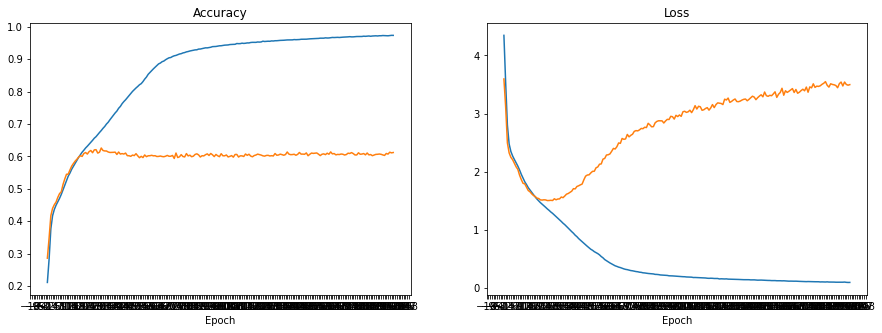

In [18]:
plot_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

Evaluate

In [19]:
def add_randomness(arr, r):
  rand_arr = [1.0 + random.uniform(-r, r) for _ in arr]
  rand_arr = np.array(rand_arr, dtype = float)
  return np.multiply(arr, rand_arr)

In [39]:
def beam_search(line, max_length=1000, beam_width=10, random_factor=0.1):
  '''
  Parameters
  ----------
  line : str
      The input line
  max_length : int, optional
      The max length in tokens of the output string (default is 1000)
  beam_wodth : int, optional
      The number of beams (default is 10)
  random_factor : float, optional
      To get a non-deterministic solution
  '''
  line = tf.convert_to_tensor([line])
  encoder_input = tokenizer.tokenize(line).to_tensor()

  start, end = tokenizer.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)

  # predictions.shape == (batch_size, seq_len, vocab_size)
  predictions, attention_weights = transformer.call((encoder_input, output),
                                              False)
  predictions = tf.nn.softmax(predictions, axis=-1)
  # select the last word from the seq_len dimension
  predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
  predictions = add_randomness(predictions.numpy()[0][0], random_factor) 
  predictions = np.log(predictions)
  tokens = np.argpartition(predictions, -beam_width)[-beam_width:]
  probabilities = predictions[tokens]
  beams = []
  for token in tokens:
    token = tf.convert_to_tensor([token], dtype=tf.int64)
    token = tf.expand_dims(token, 0)
    beams.append(tf.concat([output, token], axis=-1))

  for j in range(max_length-1):
    n_ended = 0
    candidates = []
    candidates_probs = []
    is_all_ended = True
    for k, beam in enumerate(beams):
      if beam.numpy()[0][-1] != end:
        is_all_ended = False
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer.call((encoder_input, beam),
                                                    False)
        predictions = tf.nn.softmax(predictions, axis=-1)
        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
        predictions = add_randomness(predictions.numpy()[0][0], random_factor) 
        predictions = np.log(predictions)
        indeces = np.argpartition(predictions, -beam_width)[-beam_width:]
        values = predictions[indeces] + probabilities[k]
        for index, prob in zip(indeces, values):
          index = tf.convert_to_tensor([index], dtype=tf.int64)
          index = tf.expand_dims(index, 0)
          candidates.append(tf.concat([beam, index], axis=-1))
          candidates_probs.append(prob)
      else:
        n_ended += 1
    print(beams)
    if is_all_ended:
      break
    best_probs = np.argpartition(candidates_probs, -(beam_width-n_ended))[-(beam_width-n_ended):]
    counter = 0
    for i in range(len(beams)):
      if beams[i].numpy()[0][-1] != end:
        beams[i] = candidates[best_probs[counter]]
        probabilities[i] = candidates_probs[best_probs[counter]]
        counter += 1

  text = tokenizer.detokenize(beams[0])[0]
  tokens = tokenizer.lookup(beams[0])[0]
  return text, tokens, attention_weights
  

In [21]:
def top_k(line, max_length=1000, k=1, r=1.0):
  '''
  Parameters
  ----------
  line : str
      The input line
  max_length : int, optional
      The max length in tokens of the output string (default is 1000)
  k : int, optional
      The parameter k of top-k sampling, with 1 the function behaves as a
      standard greedy selection (default is 1)
  r : float, optional
      sampling is applied with probability r, so with r=0.0 the function behaves
      as a standard greedy selection, with r=1.0 as a standard top-k sampling
      (default is 1.0)
  '''
  line = tf.convert_to_tensor([line])
  line = tokenizer.tokenize(line).to_tensor()

  encoder_input = line

  start, end = tokenizer.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)

  for i in range(max_length):
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer.call((encoder_input, output),
                                                 False)
    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
    if i > 0 and random.random() < r:
      predictions = tf.nn.softmax(predictions, axis=-1)
      top = tf.math.top_k(predictions.numpy()[0][0], k=k)
      predicted_id = random.choices(top.indices.numpy(), weights=top.values.numpy(), k=1)
      predicted_id = tf.convert_to_tensor([predicted_id], dtype=tf.int64)
    else:
      predicted_id = tf.argmax(predictions, axis=-1)
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)
    # return the result if the predicted_id is equal to the end token
    if predicted_id == end:
      break

  # output.shape (1, tokens)
  text = tokenizer.detokenize(output)[0]
  tokens = tokenizer.lookup(output)[0]
  return text, tokens, attention_weights

In [26]:
def print_prediction(x, true=None, add_spaces=True):
  if true is None:
    true = 'Not provided\n'

  if add_spaces:
    x = re.sub(' ', ' S ', x)
  
  predicted, _, _ = beam_search(x)
  predicted = predicted.numpy().decode('utf-8')
  x = re.sub(' S ', ' ', x)
  print(f'Original:\n{x}\n')
  print(f'Predicted:\n{predicted}\n')
  print(f'True:\n{true}\n')
  print('#'*50)

In [40]:
test = dataset['test']
for batch, (x, y) in enumerate(test.batch(1)):
  if batch > 0:
    x = x.numpy()[0].decode('utf-8')
    y = y.numpy()[0].decode('utf-8')
    print_prediction(x, y, add_spaces=False)
    if batch >=10:
      break

Output streaming troncato alle ultime 5000 righe.
          2,  20, 144,   2,  52,   4, 160,   2,  54,   2,  78,   4,  19,
          2, 108]])>, <tf.Tensor: shape=(1, 67), dtype=int64, numpy=
array([[  0,   4,   2,  45,   2,  64,  51,   4,   2,  10, 136,   4,   2,
         10,  70,   2,  76,   4,   6,   4,   2,  12,  99,   2,  50,   4,
          3,  46,   4,   2, 106,   4,   2,  45,   2,  46,   5,   2, 103,
          2,  81,   4,   2,  46,   4,   2,  47,   4,   2,  23, 135,  59,
          2,  62,  43,   2, 117,   4,   3,  66,   4,  42,  17,   2,  20,
        116,   2]])>, <tf.Tensor: shape=(1, 2), dtype=int64, numpy=array([[0, 1]])>, <tf.Tensor: shape=(1, 67), dtype=int64, numpy=
array([[  0,   4,   2,  45,   2,  64,  51,   4,   2,  10, 136,   4,   2,
         10,  70,   2,  76,   4,   6,   4,   2,  12,  99,   2,  50,   4,
          3,  46,   4,   2, 106,   4,   2,  45,   2,  46,   5,   2, 103,
          2,  81,   4,   2,  46,   4,   2,  47,   4,   2,  23, 135,  59,
          2,  62,  

KeyboardInterrupt: ignored

In [24]:
test = dataset['test']
pick = random.randint(0,20)
tercets = random.randint(10, 10)
for i, (x, y) in enumerate(test.batch(1)):
  if i == pick:
    seed = x.numpy()[0].decode('utf-8')
    break
print('seed:\n' + re.sub(' S ', ' ', re.sub(' N ', '\n ', seed)) + '\n')
print('---generated:---\n')
for i in range(tercets):
  predicted, _, _ = top_k(seed, k=2, r=0.5)
  predicted = predicted.numpy().decode('utf-8')
  predicted = re.sub('[|$]', '', predicted)
  print(predicted + '\n')
  x = re.sub('[|$]', '', re.sub(r'\n', ' N ', re.sub(' ', ' S ', predicted)))

seed:
 poi che noi fummo in su l’ orlo suppremo
 de l’ alta ripa a la scoperta piaggia
 maestro mio diss’ io che via faremo 

---generated:---

e io a lui s’ esser puose io vorrei
che de lo smisurato brïareo
esperïenza avesser li occhi mei

e io a lui s’ esser puose io vorrei
che de lo smisurato brïareo
esperïenza avesser li occhi mei

e io a lui s’ esser puose io vorrei
che de lo smisurato brïareo
esperïenza avesser li occhi mei

e io a lui s’ esser puosere io vorrei
che de lo scoglio che per la sua posta
e sola mia tremar perché promei

e io a lui s’ esser puose io vorrei
che de lo smisurato brïareo
esperïenza avesser li occhi mei

e quel nasetto che stretto a consiglio
par con colui c’ ha sì benigno aspetto
morì fuggendo e disfiorando il giglio

e io a lui s’ esser puose io vorrei
che de lo smisurato brïareo
esperïenza avesser li occhi me

e quelli o figliuol mio non ti dispiaccia
se brunetto latino un poco teco
ritorna ’n dietro e lascia andar la traccia

e io a lui s’ esser puose 